# Deep Learning for solving Argument Mining task

Main argument mining task:

- Argumentative fragment detection
- Argument component classification
- Argumentative relation recognition

## Task 2 - Argument component classification

### Loading the data

In [1]:
# Mount Drive files
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import os

In [3]:
def load_sst_data(path: str):
  data = pd.read_csv(path)
  return data

sst_home = "drive/My Drive/Datasets/dm-2019/dm-2019-annotated.csv"
dataset = load_sst_data(sst_home)
dataset

,sent_id,sent_text,sent_label1,sent_label2,sent_label3
0,109-0-0,Limpieza de graffitis y remodelación de aluche,YES,CLAIM,NONE
1,109-0-0,Los vecinos de Aluche vemos día tras día como ...,YES,CLAIM,NONE
2,109-0-0,Los vecinos de Aluche vemos día tras día como ...,YES,CLAIM,NONE
3,109-0-1,"Graffitis y basura por todas partes, aceras ro...",YES,CLAIM,NONE
4,109-17276-0,No a los ruidos.,YES,CLAIM,NONE
...,...,...,...,...,...
3249,89-78258-1,Os recuerdo que España es el país de la OCDE d...,YES,PREMISE,EXPLANATION
3250,89-78258-2,La desigualdad en España avanza a un ritmo que...,YES,PREMISE,EXPLANATION
3251,89-78258-3,La pobreza y la exclusión en España han aument...,NO,SPAM,NONE
3252,89-78258-4,"Por otra lado, estamos a la espera de que nos ...",NO,SPAM,NONE


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

def split_data(df, target_column, test_size=0.2, validation_size=0.1, random_state=None):

    # Split the data into a temporary train set and test/validation set
    train, temp = train_test_split(df, test_size=(test_size + validation_size), stratify=df[target_column], random_state=random_state)

    # Split the temp set into validation and test sets
    test, validation = train_test_split(temp, test_size=validation_size / (test_size + validation_size), stratify=temp[target_column], random_state=random_state)

    return train, validation, test

In [5]:
label_column = "sent_label2"
label_dict = {"SPAM": 0, "CLAIM": 1, "PREMISE": 2}

t1_data = dataset[["sent_text", label_column]]
t1_data = t1_data.replace({label_column: label_dict})

training_set, dev_set, test_set = split_data(t1_data, target_column=label_column, test_size=0.1, validation_size=0.1, random_state=42)

Validation of stratified split:

In [6]:
# Shuffle dataset
training_set = shuffle(training_set)
dev_set = shuffle(dev_set)
test_set = shuffle(test_set)

# Obtain text and label vectors
train_texts = training_set["sent_text"]
train_labels = training_set[label_column]

dev_texts = dev_set["sent_text"]
dev_labels = dev_set[label_column]

test_texts = test_set["sent_text"]
test_labels = test_set[label_column]

print("Training size: {}".format(len(training_set)))
print("Dev size: {}".format(len(dev_set)))
print("Test size: {}".format(len(test_set)))

Training size: 2603
Dev size: 326
Test size: 325


In [7]:
print(f"Training classes:\n{train_labels.value_counts() / len(train_labels)}")

Training classes:
0    0.551287
1    0.283519
2    0.165194
Name: sent_label2, dtype: float64


In [8]:
print(f"Dev classes:\n{dev_labels.value_counts() / len(dev_labels)}")

Dev classes:
0    0.552147
1    0.282209
2    0.165644
Name: sent_label2, dtype: float64


In [9]:
print(f"Test classes:\n{test_labels.value_counts() / len(test_labels)}")

Test classes:
0    0.550769
1    0.283077
2    0.166154
Name: sent_label2, dtype: float64


### Installing and seting up the Transformers library

In [10]:
import tensorflow as tf

## for replicability of results
tf.random.set_seed(2)

In [11]:
# https://blog.tensorflow.org/2019/11/hugging-face-state-of-art-natural.html
!pip install transformers

Once the transformers library is installed, we can use it directly just creating three object of two classes:

- The tokenizer class
- The model class

The contextualized model in Spanish that we are going to use is BETO: https://github.com/dccuchile/beto

- HuggingFace cased model: https://huggingface.co/dccuchile/bert-base-spanish-wwm-cased
- HuggingFace uncased model: https://huggingface.co/dccuchile/bert-base-spanish-wwm-uncased

In [12]:
from transformers import TFBertForSequenceClassification, BertTokenizer

hf_model_name = "dccuchile/bert-base-spanish-wwm-cased"
model = TFBertForSequenceClassification.from_pretrained(hf_model_name)
tokenizer = BertTokenizer.from_pretrained(hf_model_name)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['classifier', 'bert/pooler/dense/bias:0', 'bert/pooler/dense/kernel:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Next we will define two helper function to 1) extract features from the tokenizer (`convert_examples_to_features`) and 2) convert the features to `tf.data.Dataset` object class (`convert_features_to_tf_dataset`). `tf.data.Dataset` is a convinient API that helps managing and iterating in efficient way the input and output data of the model.  For more information you can check the API in tensorflow web page: https://www.tensorflow.org/api_docs/python/tf/data/Dataset.

In [13]:
from transformers import InputFeatures

def convert_examples_to_features(texts, labels):
  labels = list(labels)
  batch_encoding = tokenizer.batch_encode_plus(texts, max_length=128, padding='longest')

  features = []
  for i in range(len(texts)):
      inputs = {k: batch_encoding[k][i] for k in batch_encoding}

      feature = InputFeatures(**inputs, label=labels[i])
      features.append(feature)

  for i, example in enumerate(texts[:5]):
      print("*** Example ***")
      print("text: %s" % (example))
      print("features: %s" % features[i])

  return features

def convert_features_to_tf_dataset(features):
  def gen():
      for ex in features:
          yield ({
              "input_ids": ex.input_ids,
              "attention_mask": ex.attention_mask,
              "token_type_ids": ex.token_type_ids
              }, ex.label)

  output_types = ({
      "input_ids": tf.int32,
      "attention_mask": tf.int32,
      "token_type_ids": tf.int32
      }, tf.int32)

  output_shapes = ({
      "input_ids": tf.TensorShape([None]),
      "attention_mask": tf.TensorShape([None]),
      "token_type_ids": tf.TensorShape([None])
      }, tf.TensorShape([]))

  dataset = tf.data.Dataset.from_generator(gen, output_types, output_shapes)
  return dataset

Model hyper-params:

In [14]:
batch_size = 16
num_epochs = 5

Let's preprocess the training and development sets. Note that we use the `tf.data.Dataset` API to set the batch size to 16.

In [15]:
train_features = convert_examples_to_features(train_texts, train_labels)
train_dataset = convert_features_to_tf_dataset(train_features)

dev_features = convert_examples_to_features(dev_texts, dev_labels)
dev_dataset = convert_features_to_tf_dataset(dev_features)

train_dataset = train_dataset.shuffle(100).batch(batch_size)
dev_dataset = dev_dataset.batch(batch_size)

*** Example ***
text: Si no hay un buen transporte público, Madrid seguirá siendo un caos circulatorio.
features: InputFeatures(input_ids=[4, 1339, 1084, 1423, 1049, 1594, 3813, 3184, 1017, 5233, 10655, 2721, 1049, 15480, 23978, 20443, 30933, 1009, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], attention_mask=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [16]:
# Take one bacth of 16 examples
instance = list(train_dataset.take(1).as_numpy_iterator())
print(instance)

[({'input_ids': array([[    4,  5650,  1030, ...,     1,     1,     1],
       [    4,  7041,  1835, ...,     1,     1,     1],
       [    4,  1187,  1403, ...,     1,     1,     1],
       ...,
       [    4, 15847,  1996, ...,     1,     1,     1],
       [    4,  2144,  8936, ...,     1,     1,     1],
       [    4,  1894,  1105, ...,     1,     1,     1]], dtype=int32), 'attention_mask': array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32), 'token_type_ids': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)}, array([2, 2, 1, 1, 0, 2, 2, 0, 0, 0, 1, 0, 1, 2, 2, 0], dtype=int32))]


### Understanding the tokenizer

In [17]:
sentence1 = train_texts.iloc[0]

# Tokenize sentence
sentence1_tokenized = tokenizer.tokenize(sentence1)
print("0. INPUT SENTENCE: {}".format(sentence1))
print("1. TOKENIZED SENTENCE: {}".format(sentence1_tokenized))

# Add Special tokens
sentence1_tokenized_with_special_tokens = ["[CLS]"] + sentence1_tokenized + ["[SEP]"]
print("2. ADD [CLS], [SEP]: {}".format(sentence1_tokenized_with_special_tokens))
sentence1_ids = tokenizer.convert_tokens_to_ids(sentence1_tokenized_with_special_tokens)

# Convert to ids
print("3. SENTENCE IDS: {}".format(sentence1_ids))

0. INPUT SENTENCE: Si no hay un buen transporte público, Madrid seguirá siendo un caos circulatorio.
1. TOKENIZED SENTENCE: ['Si', 'no', 'hay', 'un', 'buen', 'transporte', 'público', ',', 'Madrid', 'seguirá', 'siendo', 'un', 'caos', 'circul', '##atori', '##o', '.']
2. ADD [CLS], [SEP]: ['[CLS]', 'Si', 'no', 'hay', 'un', 'buen', 'transporte', 'público', ',', 'Madrid', 'seguirá', 'siendo', 'un', 'caos', 'circul', '##atori', '##o', '.', '[SEP]']
3. SENTENCE IDS: [4, 1339, 1084, 1423, 1049, 1594, 3813, 3184, 1017, 5233, 10655, 2721, 1049, 15480, 23978, 20443, 30933, 1009, 5]


### Fine-tune BETO as Sentence Classifier

In [27]:
# Prepare training: Compile tf.keras model with optimizer, loss and learning rate schedule
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy("accuracy")
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

# Train and evaluate using tf.keras.Model.fit()
history = model.fit(train_dataset, epochs=num_epochs, validation_data=dev_dataset)

Epoch 1/5
163/163 [==============================] - 199s 830ms/step - loss: nan - accuracy: 0.5509 - val_loss: nan - val_accuracy: 0.5521
Epoch 2/5
163/163 [==============================] - 116s 710ms/step - loss: nan - accuracy: 0.5513 - val_loss: nan - val_accuracy: 0.5521
Epoch 3/5
163/163 [==============================] - 102s 629ms/step - loss: nan - accuracy: 0.5513 - val_loss: nan - val_accuracy: 0.5521
Epoch 4/5
163/163 [==============================] - 102s 629ms/step - loss: nan - accuracy: 0.5513 - val_loss: nan - val_accuracy: 0.5521
Epoch 5/5
163/163 [==============================] - 101s 620ms/step - loss: nan - accuracy: 0.5513 - val_loss: nan - val_accuracy: 0.5521


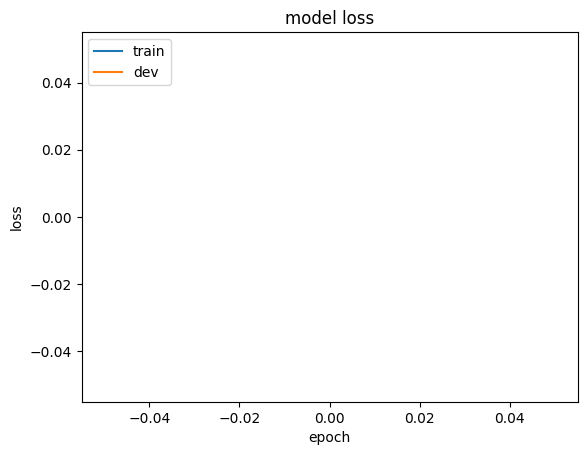

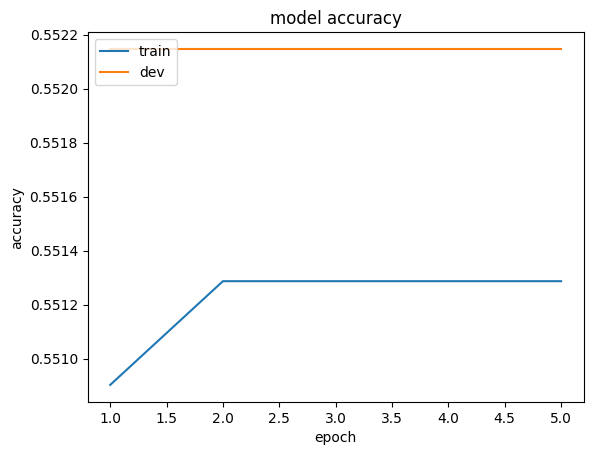

In [28]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

# summarize history for accuracy
plt.plot(epochs, history.history["loss"])
plt.plot(epochs, history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "dev"], loc="upper left")
plt.show()

# summarize history for accuracy
plt.plot(epochs, history.history["accuracy"])
plt.plot(epochs, history.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "dev"], loc="upper left")
plt.show()

### Testing out model

Once the model is fine-tuned for sentiment analysis we could evaluate it on the test set. In this we need to tokenized and convert to ids the input too.

In [34]:
test_features = convert_examples_to_features(test_texts, test_labels)
test_dataset = convert_features_to_tf_dataset(test_features)

*** Example ***
text: Y para los graffitis que son arte restauración de paredes en solares y lugares públicos donde mostrar su habilidad.
features: InputFeatures(input_ids=[4, 1175, 1110, 1065, 2019, 3393, 15050, 30934, 1038, 1404, 4868, 13126, 1008, 11244, 1036, 21287, 1042, 4935, 5481, 1748, 5905, 1079, 11316, 1009, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], attention_mask=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [35]:
test_dataset = test_dataset.batch(batch_size)
instances = list(test_dataset.take(1).as_numpy_iterator())
instances

[({'input_ids': array([[   4, 1175, 1110, ...,    1,    1,    1],
          [   4, 1177, 1157, ...,    1,    1,    1],
          [   4, 1187, 1403, ...,    1,    1,    1],
          ...,
          [   4, 5415, 1659, ...,    1,    1,    1],
          [   4, 1584, 1084, ...,    1,    1,    1],
          [   4, 7332, 1018, ...,    1,    1,    1]], dtype=int32),
   'attention_mask': array([[1, 1, 1, ..., 0, 0, 0],
          [1, 1, 1, ..., 0, 0, 0],
          [1, 1, 1, ..., 0, 0, 0],
          ...,
          [1, 1, 1, ..., 0, 0, 0],
          [1, 1, 1, ..., 0, 0, 0],
          [1, 1, 1, ..., 0, 0, 0]], dtype=int32),
   'token_type_ids': array([[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]], dtype=int32)},
  array([2, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1], dtype=int32))]

In [36]:
loss, accuracy = model.evaluate(test_dataset)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

21/21 [==============================] - 3s 147ms/step - loss: nan - accuracy: 0.5508
Loss: nan
Accuracy: 0.5507692098617554


### Serialize and save model

In [ ]:
# Serialize model to JSON
model_home = "drive/My Drive/Datasets/dm-2019/models/"
model_json = model.to_json()
with open(model_home + "am-t2-beto-model.json", "w") as json_file:
    json_file.write(model_json)

# Serialize weights to HDF5
model.save_weights(model_home + "am-t2-beto-model.h5")

---

You can check how much GPU/CPU you are using in your colab sessions.

In [ ]:
# Memory footprint support libraries/code
!pip install gputil
!pip install psutil
!pip install humanize

import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()

# Only one GPU on Colab and isn't guaranteed
gpu = GPUs[0]

def printm():
  process = psutil.Process(os.getpid())
  print("Gen RAM Free:", humanize.naturalsize(psutil.virtual_memory().available), "I Proc size:", humanize.naturalsize( process.memory_info().rss))
  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

printm()